# Advanced model fitting: calibrating the MONARCH model

## Introduction
The goal of this notebook is to calibrate our lab's MONARCH model to a synthetic data set, as published in Jones & Oomen [1]. We will generate a synthetic data set using MONARCH and calibrate the model to this synthetic data using CHAMLEON to check if we can recapitulate the known model parameters. We will calibrate a single heart beat simulation as well as a growth simulation. The outline will be:
1. Generating the synthetic data
2. Fitting the baseline model
3. Fitting the chronic model

In [1]:
# Enable automatically reloading modules when they have changed
%load_ext autoreload
%autoreload 2

When rerunning this notebook, set the run_sims variable to false to skip the simulation step and only run the GPEs and implausibility calculations. Simulations ran previously will be loaded and this will tremendously speed up the process.

In [2]:
import pathlib

main_dir = pathlib.Path.cwd() / "demo_monarch"
run_sims = True

## Generating the synthetic data
### Running simulation
The MONARCH model platform is a system of ordinary differential equations (ODEs) that describes cardiac physiology, mechanics and growth. The model is described in detail in [1]. First, import the model and initialize it with the default parameters from an input file designed to simulate volume overload in canines (from MONARCH's GitHub repository).

In [3]:
from monarch import Hatch

# Initialize model
input_vo = "canine_vo"
beats = Hatch(input_vo)

We want to set a few constants to ensure a realistic wall geometry of all ventricles at all times. This is important because we only want to fit the LV parameters in this case, and want to have realistic geometries for the other chambers for every chosen parameter set. These constants include a ratio of midwall reference areas takes from [2], and the wall thicknesses of all other chambers than the LV at end-diastole from [3].

In [4]:
model_constants = {"AmRefRfwRatio": 1.36, "AmRefSwRatio": 0.53, "AmRefLARatio": 0.70, "AmRefRARatio": 0.51,
                   "RfWth": 3.4, "LAWth": 3.9, "RAWth": 3.9, "SWth": 10.3,
                   "RfwVRatio": 0.584, "SwVRatio": 0.607, "LAWVRatio": 0.0924, "RAWVRatio": 0.0410}

beats.change_pars(model_constants)

Now we run the growth simulation. The input file is set up to run 90 days of volume overload by decreasing a parameter named `rmvb`, or mitral valve backflow resistance, which causes mitral regurgitation. Note that running this cell for the first time may be time-consuming as the model needs to be compiled, rerunning the cell will be much faster.

In [5]:
# Run baseline simulation and store results to enable plotting results
beats.let_it_grow()

We can plot the results of these simulations, first the change in metrics that are being used in the clinic to evaluate cardiac health:

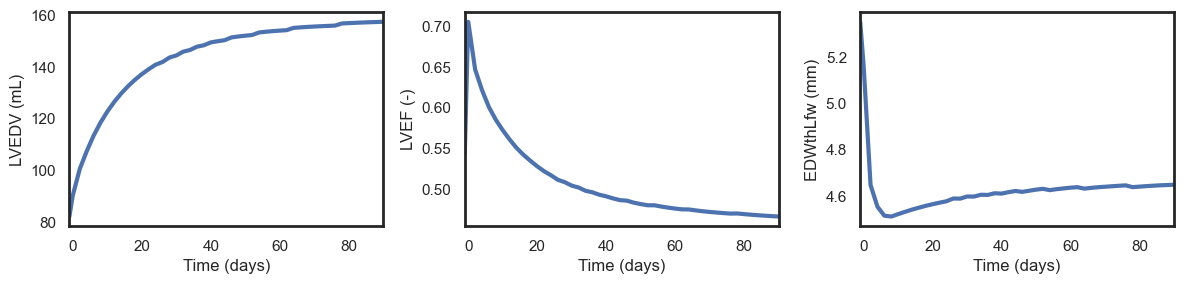

In [6]:
import monarch.metamophoses as meta

meta.plot_growth(beats, ["LVEDV", "LVEF", "EDWthLfw"], units=["mL", "-", "mm"])

A more rigorous analysis would be to inspect the left ventricle pressure volume loops over time. Note how after inducing mitral regurgitation (day 0), the loop gets wider and the maximum pressure decreases. After 90 days, cardiac growth has increased cavity volume, noticeable by the shift of the loop to the right. 

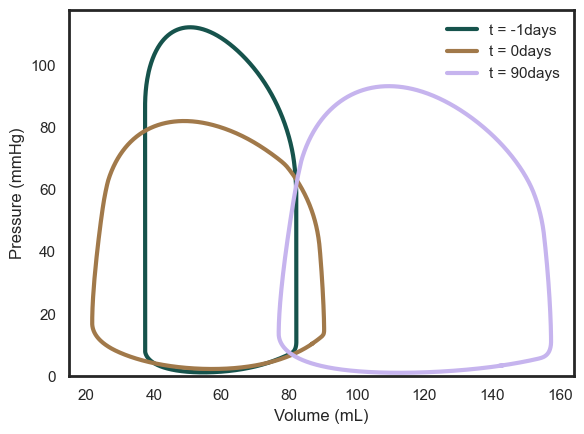

In [7]:
meta.pv_loop_growth(beats, index=[0, 1, -1])

Let's inspect the growth of the left ventricular walls: the left free wall (LFW) and septal wall (SW). We can do this by plotting the fiber and cross-fiber growth and total growth, in this case leading to wall dilation and thinning, resp.

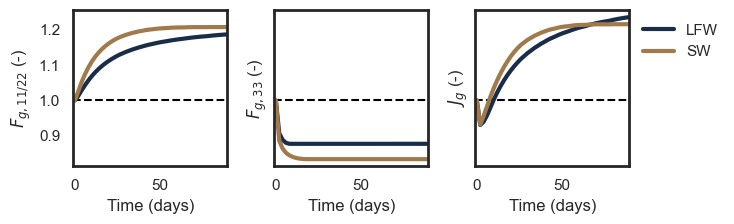

In [8]:
meta.plot_fg(beats, walls=[0, 2])

### Extracting the data
We want to extract the data from the growth simulation to use it for fitting. We can do this by extracting certain values of interest from the *outputs* table in the model instance at certain time points. Let's first choose the metrics that we will match and the time points at which we will match these. We also choose a standard deviation, in this case 10%–rerun this notebook with different confidence levels to see how the results change, as in Jones & Oomen [1].

In [9]:
# Outputs of interest
roi = ["LVEDV", "LVESV", "LVEF", "LVEDP", "MAP", "EDWthLfw", "LVRF"]

# Time points of interest
t = [-1, 0, 30, 60, 90]

# Confidence level, set artificial standard deviation
ci_data = 0.1

We now extract the values from the model class. Setting certain mu values to NaN will exclude them from the fitting process; for example, we want to exclude the regurgitant fraction (LVRF) from the baseline model since it will always be (close to) 0.

In [10]:
import numpy as np

# Obtain outputs of interest from the growth simulation 
# Time points -1 and 0 are equal to the baseline and acute simulations, resp.
data_mean = beats.growth.outputs[roi].loc[t]
data_mean.loc[-1, "LVRF"] = np.nan

# We here assume that the standard deviation is 10% of the mean
data_std = ci_data * abs(data_mean)

# Display table
print("Mean:")
display(data_mean)
print("Standard deviation:")
display(data_std)

Mean:


,LVEDV,LVESV,LVEF,LVEDP,MAP,EDWthLfw,LVRF
-1,82.154555,37.434113,0.544345,11.157981,70.732071,5.351986,NaN
0,90.371149,26.642898,0.705184,14.847681,51.577321,5.160594,0.523101
30,144.449137,71.545808,0.504699,11.840621,56.713453,4.598245,0.545007
60,154.057604,80.634187,0.476597,11.272160,57.016689,4.636224,0.547469
90,157.461759,83.947924,0.466868,11.212217,57.089963,4.648908,0.548078


Standard deviation:


,LVEDV,LVESV,LVEF,LVEDP,MAP,EDWthLfw,LVRF
-1,8.215455,3.743411,0.054435,1.115798,7.073207,0.535199,NaN
0,9.037115,2.664290,0.070518,1.484768,5.157732,0.516059,0.052310
30,14.444914,7.154581,0.050470,1.184062,5.671345,0.459825,0.054501
60,15.405760,8.063419,0.047660,1.127216,5.701669,0.463622,0.054747
90,15.746176,8.394792,0.046687,1.121222,5.708996,0.464891,0.054808


We can also set some metadata such as lower and upper limits. The limits represent physiological limits of each data point: any emulated value that falls outside of these values will be rejected. We do this to prevent that model instabilities will impede the training of the emulators that will be used to accelerate parameter evaluations. It is recommended to set these values generously to prevent relevant simulations being rejected.

In [11]:
import pandas as pd

# Set physiological limits (same for baseline and acute and add RF for acute)
data_meta = pd.DataFrame(index=['min', 'max'], columns=roi)
data_meta.loc['min'] = [10, 0, 0, 0, 25, 2, 0]
data_meta.loc['max'] = [200, 200, 1, 40, 250, 50, 1]
data_meta

,LVEDV,LVESV,LVEF,LVEDP,MAP,EDWthLfw,LVRF
min,10,0,0,0,25,2,0
max,200,200,1,40,250,50,1


#### Baseline
CHAMELEON's Camouflage class is expecting a Pandas dataframe with all information for each output variable, which we set up here. We need `mu` (mean) and `sigma` (standard deviation), and optional the lower and upper limits labeled as `min` and `max`, resp. The time point of needs to be specified by `_label`, for a non-growth simulation this can be `_baseline` and/or `_acute`. We provide a utility function to convert the data to this format, and save it as a .csv file for documentation.

In [12]:
from chameleon.utils import convert_data

roi_baseline = ["LVEDV", "LVESV", "LVEF", "LVEDP", "MAP", "EDWthLfw", "LVRF"]
t = [-1, 0]

# Convert data to Pandas dataframe
data_dir = main_dir / "data"
data_baseline = convert_data(data_mean[roi_baseline].loc[t], data_std[roi_baseline].loc[t], meta=data_meta[roi_baseline],
                             csv_dir=data_dir, csv_name="data_baseline")
data_baseline

,mu_baseline,mu_acute,sigma_baseline,sigma_acute,min,max
LVEDV,82.154555,90.371149,8.215455,9.037115,10,200
LVESV,37.434113,26.642898,3.743411,2.664290,0,200
LVEF,0.544345,0.705184,0.054435,0.070518,0,1
LVEDP,11.157981,14.847681,1.115798,1.484768,0,40
MAP,70.732071,51.577321,7.073207,5.157732,25,250
EDWthLfw,5.351986,5.160594,0.535199,0.516059,2,50
LVRF,NaN,0.523101,NaN,0.052310,0,1


#### Growth
For growth, we only analyze LVEDV, EDWthLfw, and LVEF. We use the same utility function but specify the columns of interest and specify growth = True to get the correct format for a growth simulation, i.e. labels are `_d#` (where `#` is growth day) instead of baseline/acute. 

In [13]:
roi_growth = ["LVEDV", "EDWthLfw", "LVEF"]
t = [-1, 0, 30, 60, 90]

# Convert data to Pandas dataframe
data_growth = convert_data(data_mean[roi_growth].loc[t], data_std[roi_growth].loc[t], growth=True,
                                  meta=data_meta[roi_growth], csv_dir=data_dir, csv_name="data_growth")
data_growth

,mu_d-1,mu_d0,mu_d30,mu_d60,mu_d90,sigma_d-1,sigma_d0,sigma_d30,sigma_d60,sigma_d90,min,max
LVEDV,82.154555,90.371149,144.449137,154.057604,157.461759,8.215455,9.037115,14.444914,15.405760,15.746176,10,200
EDWthLfw,5.351986,5.160594,4.598245,4.636224,4.648908,0.535199,0.516059,0.459825,0.463622,0.464891,2,50
LVEF,0.544345,0.705184,0.504699,0.476597,0.466868,0.054435,0.070518,0.050470,0.047660,0.046687,0,1


## Global sensitivity analysis
Before running the BHM, it is good practice to perform a sensitivity analysis. This can help you identify parameters or readouts that are irrelevant to the fitting process, and thus can be excluded from the fitting process and set constant. We will use the SALib package to perform a Sobol sensitivity analysis. In most models, performing a global sensitivity analysis is computationally expensive, so here take advantage of the low computational cost of the emulators to perform the analysis. 

First, decide what parameters to fit and what their expected ranges are, and compile them in a list of dictionaries (one for each parameter). It is crucial that the labels match (case-insensitive) the label names in MONARCH's change_pars function. A list of the supported parameters can be called using `monarch.utils.list_change_pars`.

In [14]:
pars = {
        "SAct": {"limits": [0.050, 0.200]},
        "AmRefLfw": {"limits": [4e3, 10e3]},
        "c3": {"limits": [5e-6, 5e-3]},
        "VLfw": {"limits": [40e3, 70e3]},
        "SBV": {"limits": [300, 1500]},
        "Ras": {"limits": [0.3, 5.0]},
        "Rmvb_acute": {"limits": [0.05, 2.0]}
    }

Set up the Camouflage class, making sure to run sufficient simulations to properly train the emulators. Similarly, use enough emulation points to get a good estimate of the Sobol indices. A minimum of `n_emu0` = $2^{11}$ = 2048 is generally recommended in the literature for this, so we go one order higher ($2^{12}$) just to be sure.


In [15]:
from chameleon import Camouflage

# Set up directories to store results
sense_dir = main_dir / "sensitivity"

# Setting up the wave class
wave = Camouflage(0, sense_dir, 5.0, pars, data_baseline, nroy=None, n_sim=2**8,
                  clear_log=True, n_emu0=2**12, n_emu_min=2**12)

-----------
Parameters:
-----------
- SAct: [0.05 - 0.2]
- AmRefLfw: [4000.0 - 10000.0]
- c3: [5e-06 - 0.005]
- VLfw: [40000.0 - 70000.0]
- SBV: [300.0 - 1500.0]
- Ras: [0.3 - 5.0]
- Rmvb_acute: [0.05 - 2.0]


-------------
Observations:
-------------
- LVEDV: 82.1545545731885 ± 8.215455457318852
- LVESV: 37.434112835957976 ± 3.7434112835957976
- LVEF: 0.5443452523060145 ± 0.05443452523060145
- LVEDP: 11.157980782155246 ± 1.1157980782155246
- MAP: 70.73207139403667 ± 7.073207139403667
- EDWthLfw: 5.351986438858508 ± 0.5351986438858508
- LVEDV_acute: 90.37114885301702 ± 9.037114885301703
- LVESV_acute: 26.642897681948316 ± 2.664289768194832
- LVEF_acute: 0.7051835898945878 ± 0.07051835898945878
- LVEDP_acute: 14.847680660945649 ± 1.484768066094565
- MAP_acute: 51.57732131824291 ± 5.157732131824291
- EDWthLfw_acute: 5.160594116715735 ± 0.5160594116715735
- LVRF_acute: 0.5231008244334605 ± 0.052310082443346055


-------------
Constants:
-------------
None specified



------
Wave 1
------

Now we will run model simulations to train the emulators. Depending on your computer, this may take several minutes. The results will be stored in the `sense_dir` / "Wave 1" directory. In contrast to the simple example in the sister notebook *simple_model*, we will need more advanced functions to run the simulations with each selected parameter set, and to obtain the output results. We will therefore included a module named `monarch_utils` that contains these functions, wrapped together in a function called `run_forest_run`. This function will run the simulations, store the results in `wave.sim_dir` (Default name "Wave #" / "sims"), and return the output results in a format that can be used by the Camouflage class. 

>Important: you can create your own version of the `monarch_utils` module to run any model of your choice, as long as it returns `x_sim` and `y_sim` in the correct format, i.e. numpy arrays with each row representing a parameter set and each column representing a different output variable, in the same order as `wave.x_names`.

Note that when running the models with the cell below, several models will not converge, throwing warning. This is expected since we are running the model with a very broad parameter space, some of which result in unrealistic and unstable solutions. This is not a problem, since the implausible parameter sets will be filtered out in the BHM process later. Running the cel will take several seconds-minutes, depending on your computer. You can set `run_sims` to false if rerunning this cell/notebook to save time.

In [16]:
import chameleon.monarch_utils as monarch_utils

# Run simulations for all parameter sets in current wave set x to train the emulators
wave.x_sim, wave.y_sim, _ = monarch_utils.run_forest_run(wave, input_vo, [], run_sims=run_sims,
                                                              constants=model_constants, log_file=wave.log_file)

Running 256 model simulations...


/Users/pimoomen/PycharmProjects/monarch/src/monarch/heart.py:298: RuntimeWarning: invalid value encountered in scalar power
  am_m_lv = np.pi ** (1 / 3) * (6 * v_m_lv) ** (2 / 3)
/Users/pimoomen/PycharmProjects/monarch/src/monarch/heart.py:304: RuntimeWarning: invalid value encountered in scalar power
  h_s = (model.heart.am_ref_w[2] * lab ** 2) / (2 * np.pi * ((3 * v_m_lv) / (4 * np.pi)) ** (1 / 3))
/Users/pimoomen/PycharmProjects/monarch/src/monarch/heart.py:307: RuntimeWarning: invalid value encountered in scalar power
  r_m = ((3 * v_m_lv) / (4 * np.pi)) ** (1 / 3)
/Users/pimoomen/PycharmProjects/monarch/src/monarch/heart.py:298: RuntimeWarning: invalid value encountered in scalar power
  am_m_lv = np.pi ** (1 / 3) * (6 * v_m_lv) ** (2 / 3)
/Users/pimoomen/PycharmProjects/monarch/src/monarch/heart.py:304: RuntimeWarning: invalid value encountered in scalar power
  h_s = (model.heart.am_ref_w[2] * lab ** 2) / (2 * np.pi * ((3 * v_m_lv) / (4 * np.pi)) ** (1 / 3))
/Users/pimoomen/Pych

256 simulation pairs (baseline + acute) completed in 34.35 seconds
228 Simulations reached convergence
179 Simulations added to training data


Use the wrapper function to run the Sobol sensitivity analysis. This will take a while, depending on your computer.

In [17]:
# Wrapper to run gpe_training_validation and sobol_sensitivity
wave.surf_sensitivity()

Training GPEs using PyTorch...
Performing sensitivity analysis...
Emulating 4096 points...
Emulation completed in 9.9 seconds


/Users/pimoomen/miniconda3/envs/chameleon/lib/python3.12/site-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


Now we plot the results of the global sensitivity analysis.

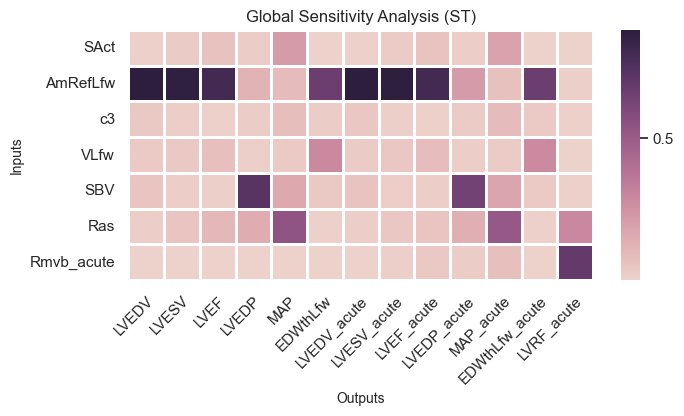

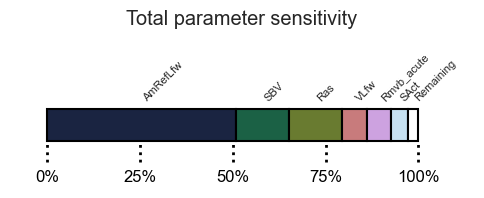

In [18]:
from chameleon import TrueColors

# Initialize TrueColors class
camo = TrueColors(sense_dir)

camo.plot_sensitivity_matrix(show_fig=True)
camo.plot_sensitivity_total(show_bar=True, cutoff=0.95)

Note that the sensitivity analysis shows that the parameter `c3` is not sensitive to any of the outputs. We will therefore exclude this parameter from the fitting process. `S_act` is on the brink of being excluded too, but we will keep it in for now.

In [19]:
# Remove c_3 from the pars dictionary
if "c3" in pars:
    pars.pop("c3")

print(pars)

{'SAct': {'limits': [0.05, 0.2]}, 'AmRefLfw': {'limits': [4000.0, 10000.0]}, 'VLfw': {'limits': [40000.0, 70000.0]}, 'SBV': {'limits': [300, 1500]}, 'Ras': {'limits': [0.3, 5.0]}, 'Rmvb_acute': {'limits': [0.05, 2.0]}}


## Calibrating the baseline model
### Run calibration
First, we store the true values of the parameters in a csv file to record and compare with the fitted values later.

In [20]:
# Reinitialize the model to clear growth results
beats = Hatch(input_vo)

# Add target values to parameter dictionary
for i, key in enumerate(pars.keys()):
    pars[key]["target"] = beats.get_pars([key])[key]

# Need to add rmvb manually since "acute" values are not support
pars["Rmvb_acute"]["target"] = float(beats.growth.rmvb[1])

Parameter rmvb_acute not found in model


We now run the entire BHM process, see the `simple_model` notebook for more details on this code fragment. Running this will take several minutes, depending on your computer. By default, we will utilize all but one CPUs on your computer. Note that, just like in the sensitivity analysis, many simulation in the early waves will crash because some very unrealistic parameter sets are included, but in later waves the model will behave much better since only non-implausible parameters sets are retained.

In [21]:
# Storage directory
baseline_dir = main_dir / "baseline"

# Initialize wave index
i_wave = 0
nroy = None
not_flooded = True
sim_dirs = []

# Start history matching until convergence is reached
while not_flooded:

    # Set wave threshold: start with 5.0 and reduce incrementally with steps of 0.5 until 2.0
    wave_threshold = max(5 - 1*i_wave, 2)
    
    # Initialize wave    
    wave = Camouflage(i_wave, baseline_dir, wave_threshold, pars, data_baseline, nroy=nroy, clear_log=(i_wave == 0), 
                constants=model_constants, n_emu0=2**18)

    # Run simulations for all parameter sets in current wave set
    wave.x_sim, wave.y_sim, sim_dirs = monarch_utils.run_forest_run(wave, input_vo, sim_dirs, constants=model_constants, 
                                                                  log_file=wave.log_file, run_sims=run_sims)

    # Run wave: train/validate emulators, emulate, calculate implausibility, find NROY
    wave.surf()

    # Check for convergence, store NROY from this wave as NROY for the next wave and update counter
    not_flooded = wave.is_flooded(i_wave, min_waves=4, max_waves=5)
    nroy = wave.nroy
    i_wave += 1

-----------
Parameters:
-----------
- SAct: [0.05 - 0.2]
- AmRefLfw: [4000.0 - 10000.0]
- VLfw: [40000.0 - 70000.0]
- SBV: [300.0 - 1500.0]
- Ras: [0.3 - 5.0]
- Rmvb_acute: [0.05 - 2.0]


-------------
Observations:
-------------
- LVEDV: 82.1545545731885 ± 8.215455457318852
- LVESV: 37.434112835957976 ± 3.7434112835957976
- LVEF: 0.5443452523060145 ± 0.05443452523060145
- LVEDP: 11.157980782155246 ± 1.1157980782155246
- MAP: 70.73207139403667 ± 7.073207139403667
- EDWthLfw: 5.351986438858508 ± 0.5351986438858508
- LVEDV_acute: 90.37114885301702 ± 9.037114885301703
- LVESV_acute: 26.642897681948316 ± 2.664289768194832
- LVEF_acute: 0.7051835898945878 ± 0.07051835898945878
- LVEDP_acute: 14.847680660945649 ± 1.484768066094565
- MAP_acute: 51.57732131824291 ± 5.157732131824291
- EDWthLfw_acute: 5.160594116715735 ± 0.5160594116715735
- LVRF_acute: 0.5231008244334605 ± 0.052310082443346055


-------------
Constants:
-------------
- AmRefRfwRatio: 1.36
- AmRefSwRatio: 0.53
- AmRefLARatio: 0

/Users/pimoomen/PycharmProjects/monarch/src/monarch/heart.py:298: RuntimeWarning: invalid value encountered in scalar power
  am_m_lv = np.pi ** (1 / 3) * (6 * v_m_lv) ** (2 / 3)
/Users/pimoomen/PycharmProjects/monarch/src/monarch/heart.py:304: RuntimeWarning: invalid value encountered in scalar power
  h_s = (model.heart.am_ref_w[2] * lab ** 2) / (2 * np.pi * ((3 * v_m_lv) / (4 * np.pi)) ** (1 / 3))
/Users/pimoomen/PycharmProjects/monarch/src/monarch/heart.py:307: RuntimeWarning: invalid value encountered in scalar power
  r_m = ((3 * v_m_lv) / (4 * np.pi)) ** (1 / 3)
/Users/pimoomen/PycharmProjects/monarch/src/monarch/heart.py:298: RuntimeWarning: invalid value encountered in scalar power
  am_m_lv = np.pi ** (1 / 3) * (6 * v_m_lv) ** (2 / 3)
/Users/pimoomen/PycharmProjects/monarch/src/monarch/heart.py:304: RuntimeWarning: invalid value encountered in scalar power
  h_s = (model.heart.am_ref_w[2] * lab ** 2) / (2 * np.pi * ((3 * v_m_lv) / (4 * np.pi)) ** (1 / 3))
/Users/pimoomen/Pych

128 simulation pairs (baseline + acute) completed in 16.84 seconds
120 Simulations reached convergence
97 Simulations added to training data
Training GPEs using PyTorch...
Emulating 262144 points...
Emulation completed in 1.61 seconds
16419 points remaining in NROY region (6.26% of original space)
LVESV_acute is the most implausible output (35.17% of all points)
15239 points remaining in NROY region after limits check
NROY size change at Wave 1 is -0.94: no convergence

------
Wave 2
------
Regenerating emulation cloud from 15239 to 100000 points...
Running 128 model simulations...


/Users/pimoomen/PycharmProjects/monarch/src/monarch/heart.py:298: RuntimeWarning: invalid value encountered in scalar power
  am_m_lv = np.pi ** (1 / 3) * (6 * v_m_lv) ** (2 / 3)
/Users/pimoomen/PycharmProjects/monarch/src/monarch/heart.py:304: RuntimeWarning: invalid value encountered in scalar power
  h_s = (model.heart.am_ref_w[2] * lab ** 2) / (2 * np.pi * ((3 * v_m_lv) / (4 * np.pi)) ** (1 / 3))
/Users/pimoomen/PycharmProjects/monarch/src/monarch/heart.py:307: RuntimeWarning: invalid value encountered in scalar power
  r_m = ((3 * v_m_lv) / (4 * np.pi)) ** (1 / 3)
/Users/pimoomen/PycharmProjects/monarch/src/monarch/heart.py:298: RuntimeWarning: invalid value encountered in scalar power
  am_m_lv = np.pi ** (1 / 3) * (6 * v_m_lv) ** (2 / 3)
/Users/pimoomen/PycharmProjects/monarch/src/monarch/heart.py:304: RuntimeWarning: invalid value encountered in scalar power
  h_s = (model.heart.am_ref_w[2] * lab ** 2) / (2 * np.pi * ((3 * v_m_lv) / (4 * np.pi)) ** (1 / 3))
/Users/pimoomen/Pych

128 simulation pairs (baseline + acute) completed in 13.54 seconds
122 Simulations reached convergence
100 Simulations added to training data
Training GPEs using PyTorch...
Emulating 100000 points...
Emulation completed in 1.17 seconds
18638 points remaining in NROY region (7.11% of original space)
LVESV_acute is the most implausible output (16.6% of all points)
18584 points remaining in NROY region after limits check
NROY size change at Wave 2 is 0.22: no convergence

------
Wave 3
------
Regenerating emulation cloud from 18584 to 100000 points...
Running 128 model simulations...


/Users/pimoomen/PycharmProjects/monarch/src/monarch/egg.py:137: RuntimeWarning: divide by zero encountered in divide
  self.volumes[0, :] = self.volumes[-1, :] * self.circulation.sbv / np.sum(self.volumes[-1, :])
/Users/pimoomen/PycharmProjects/monarch/src/monarch/heart.py:304: RuntimeWarning: invalid value encountered in scalar divide
  h_s = (model.heart.am_ref_w[2] * lab ** 2) / (2 * np.pi * ((3 * v_m_lv) / (4 * np.pi)) ** (1 / 3))
/Users/pimoomen/miniconda3/envs/chameleon/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


128 simulation pairs (baseline + acute) completed in 15.23 seconds
126 Simulations reached convergence
106 Simulations added to training data
Training GPEs using PyTorch...
Emulating 100000 points...
Emulation completed in 1.96 seconds
8962 points remaining in NROY region (3.42% of original space)
LVESV_acute is the most implausible output (13.36% of all points)
8962 points remaining in NROY region after limits check
NROY size change at Wave 3 is -0.52: no convergence

------
Wave 4
------
Regenerating emulation cloud from 8962 to 100000 points...
Running 128 model simulations...


/Users/pimoomen/PycharmProjects/monarch/src/monarch/heart.py:298: RuntimeWarning: invalid value encountered in scalar power
  am_m_lv = np.pi ** (1 / 3) * (6 * v_m_lv) ** (2 / 3)
/Users/pimoomen/PycharmProjects/monarch/src/monarch/heart.py:304: RuntimeWarning: invalid value encountered in scalar power
  h_s = (model.heart.am_ref_w[2] * lab ** 2) / (2 * np.pi * ((3 * v_m_lv) / (4 * np.pi)) ** (1 / 3))
/Users/pimoomen/PycharmProjects/monarch/src/monarch/heart.py:307: RuntimeWarning: invalid value encountered in scalar power
  r_m = ((3 * v_m_lv) / (4 * np.pi)) ** (1 / 3)
/Users/pimoomen/PycharmProjects/monarch/src/monarch/heart.py:298: RuntimeWarning: invalid value encountered in scalar power
  am_m_lv = np.pi ** (1 / 3) * (6 * v_m_lv) ** (2 / 3)
/Users/pimoomen/PycharmProjects/monarch/src/monarch/heart.py:304: RuntimeWarning: invalid value encountered in scalar power
  h_s = (model.heart.am_ref_w[2] * lab ** 2) / (2 * np.pi * ((3 * v_m_lv) / (4 * np.pi)) ** (1 / 3))
/Users/pimoomen/Pych

128 simulation pairs (baseline + acute) completed in 13.07 seconds
125 Simulations reached convergence
105 Simulations added to training data
Training GPEs using PyTorch...
Emulating 100000 points...
Emulation completed in 2.68 seconds
4787 points remaining in NROY region (1.83% of original space)
MAP is the most implausible output (17.49% of all points)
4787 points remaining in NROY region after limits check
NROY size change at Wave 4 is -0.47: no convergence

------
Wave 5
------
Regenerating emulation cloud from 4787 to 100000 points...
Running 128 model simulations...


/Users/pimoomen/PycharmProjects/monarch/src/monarch/heart.py:298: RuntimeWarning: invalid value encountered in scalar power
  am_m_lv = np.pi ** (1 / 3) * (6 * v_m_lv) ** (2 / 3)
/Users/pimoomen/PycharmProjects/monarch/src/monarch/heart.py:304: RuntimeWarning: invalid value encountered in scalar power
  h_s = (model.heart.am_ref_w[2] * lab ** 2) / (2 * np.pi * ((3 * v_m_lv) / (4 * np.pi)) ** (1 / 3))
/Users/pimoomen/PycharmProjects/monarch/src/monarch/heart.py:307: RuntimeWarning: invalid value encountered in scalar power
  r_m = ((3 * v_m_lv) / (4 * np.pi)) ** (1 / 3)


128 simulation pairs (baseline + acute) completed in 12.50 seconds
126 Simulations reached convergence
111 Simulations added to training data
Training GPEs using PyTorch...
Emulating 100000 points...
Emulation completed in 4.77 seconds
35546 points remaining in NROY region (13.56% of original space)
LVESV_acute is the most implausible output (13.95% of all points)
35546 points remaining in NROY region after limits check
NROY size change at Wave 5 is 6.43: history matching terminated because maximum allowed number of waves has been reached


### Analyzing the results
Run and plot simulations using a randomly selected subset of the posterior distribution. Compare these results with the simulation results after we just ran the single wave with implausibility criterion of 5.0 to see the vast improvement.


---------
Posterior
---------
Running 256 model simulations...
256 simulation pairs (baseline + acute) completed in 21.64 seconds
256 Simulations reached convergence
227 Simulations added to training data


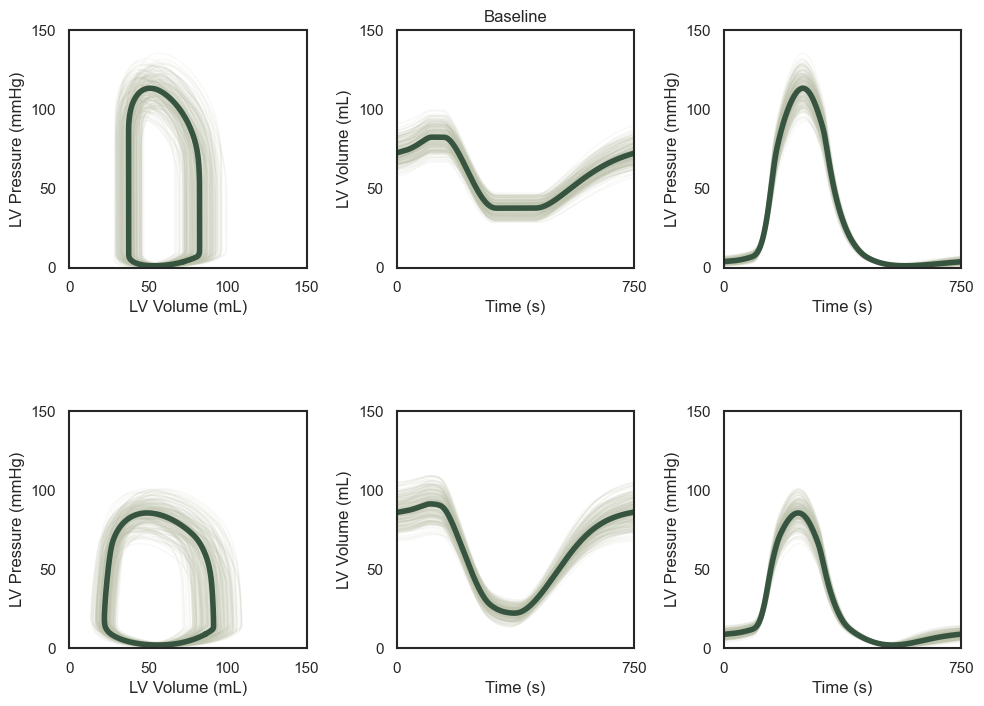

In [22]:
# Run simulations for all parameter sets in current wave set
wave.draw_posterior()
wave.x_posterior, wave.y_posterior, _ = monarch_utils.run_forest_run(wave, input_vo, [],  constants=model_constants, 
                                                         log_file=wave.log_file, show_hemo=True, posterior=True)

# Save the wave again to store the posterior results for plotting purposes
wave.pickle_wave()

Note how nicely the simulations are centered around the mean values we were trying to match. We can compare it better to the data using the TrueColors class. Start by comparing the posterior metrics to the data:

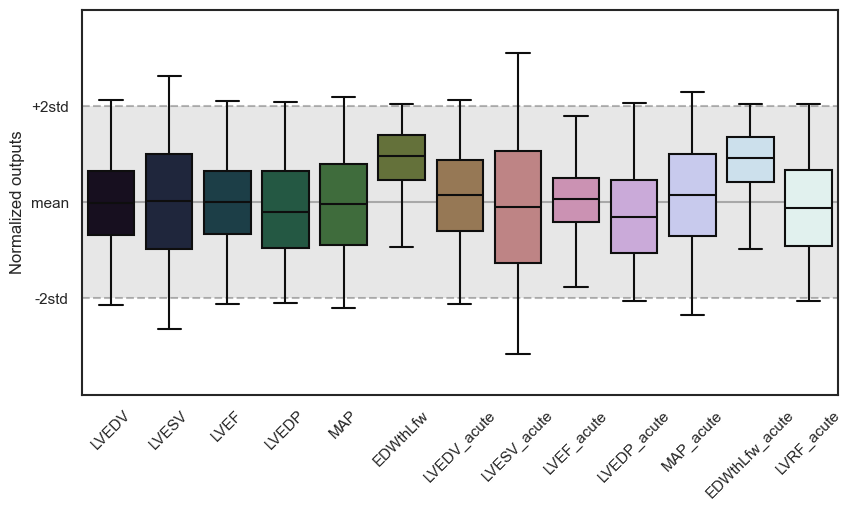

In [23]:
from chameleon import TrueColors

colors = TrueColors(baseline_dir)

# Plot the convergence of the implausibility
colors.plot_nroy_data(show_box=True)

Next, inspect the final NROY region to inspect if all parameters are uniquely fitted, and if the mean of the matched distribution is close to the true values in this synthetic case. This plot is time-consuming to generate, so we here run it with a subset of 5000 randomly chosen parameter sets.

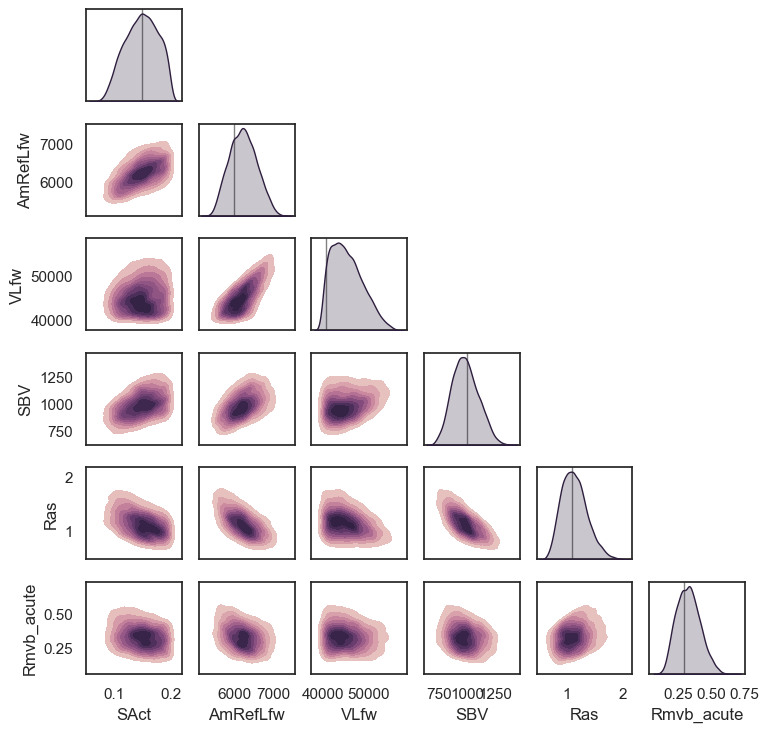

In [24]:
colors.plot_nroy_x(n_samples=5000, show_fig=True)

Note how the calibrated parameter distributions are unimodal and nicely centered around the ground truth value. Run all plots, this will be time-consuming–in fact, it is slower than running BHM itself! The plots are saved in the *results* subdirectory.

In [25]:
colors.roll(nroy_full=False)

## Calibrating the growth model
### Run calibration
This is done similar to the baseline/acute model, but now we need to specify the growth parameters and the limits:

In [26]:
# Create parameters dictionary
pars = {
    "tau_f+": {"limits": [0.1, 50.0], "target": beats.get_pars(["tau_f+"])["tau_f+"]},
    "tau_r-": {"limits": [0.1, 50.0], "target": beats.get_pars(["tau_r-"])["tau_r-"]},
}

Following Jones & Oomen [1], we will use the baseline simulation as a prior, meaning we will sample the calibrated baseline parameters. This is done in order to propagate the uncertainty of the baseline measurements into the growth parameter calibration. 

In [27]:
# Storage dDirectory
growth_dir = main_dir / "growth"

# Initialize wave index
i_wave = 0
nroy = None
not_flooded = True
sim_dirs = []

# Start history matching until convergence is reached
while not_flooded:

    # Set wave threshold: start with 5.0 and reduce incrementally with steps of 0.5 until 2.0
    wave_threshold = max(5 - 1*i_wave, 2)

    # Initialize wave
    wave = Camouflage(i_wave, growth_dir, wave_threshold, pars, data_growth, nroy=nroy, clear_log=(i_wave == 0), 
                constants=model_constants, prior_dir=baseline_dir, n_emu0=2**18)

    # Run simulations for all parameter sets in current wave set
    wave.x_sim, wave.y_sim, sim_dirs = monarch_utils.run_forest_run(wave, input_vo, sim_dirs,  constants=model_constants, 
                                                                  log_file=wave.log_file, growth=True, run_sims=run_sims)

    # Run wave: train/validate emulators, emulate, calculate implausibility, find NROY
    wave.surf()

    # Check for convergence, store NROY from this wave as NROY for the next wave and update counter
    not_flooded = wave.is_flooded(i_wave, min_waves=4, max_waves=5)
    nroy = wave.nroy
    i_wave += 1

-----------
Parameters:
-----------
- tau_f+: [0.1 - 50.0]
- tau_r-: [0.1 - 50.0]


-------------
Observations:
-------------
- LVEDV_d-1: 82.1545545731885 ± 8.215455457318852
- EDWthLfw_d-1: 5.351986438858508 ± 0.5351986438858508
- LVEF_d-1: 0.5443452523060145 ± 0.05443452523060145
- LVEDV_d0: 90.37114885301702 ± 9.037114885301703
- EDWthLfw_d0: 5.160594116715735 ± 0.5160594116715735
- LVEF_d0: 0.7051835898945878 ± 0.07051835898945878
- LVEDV_d30: 144.44913717546973 ± 14.444913717546974
- EDWthLfw_d30: 4.598245108712734 ± 0.45982451087127346
- LVEF_d30: 0.5046989590858839 ± 0.05046989590858839
- LVEDV_d60: 154.05760391032808 ± 15.405760391032809
- EDWthLfw_d60: 4.636223524298933 ± 0.46362235242989336
- LVEF_d60: 0.4765971610343514 ± 0.04765971610343514
- LVEDV_d90: 157.4617591448395 ± 15.74617591448395
- EDWthLfw_d90: 4.648908234039691 ± 0.46489082340396914
- LVEF_d90: 0.46686786711515815 ± 0.04668678671151582


-------------
Constants:
-------------
- AmRefRfwRatio: 1.36
- AmRefSwRat

/Users/pimoomen/PycharmProjects/chameleon/src/chameleon/monarch_utils.py:734: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_sims = pd.concat([df_sims, df])


Training GPEs using PyTorch...
Emulating 262144 points...
Emulation completed in 2.1 seconds
261180 points remaining in NROY region (99.63% of original space)
LVEF_d60 is the most implausible output (37.38% of all points)
261180 points remaining in NROY region after limits check
NROY size change is -0.00: convergence established but minimum number of waves (4) not yet reached

------
Wave 2
------
Running 128 model simulations...
128 growth simulations completed in 35.82 seconds
128 Simulations reached convergence
111 Simulations added to training data


/Users/pimoomen/PycharmProjects/chameleon/src/chameleon/monarch_utils.py:734: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_sims = pd.concat([df_sims, df])


Training GPEs using PyTorch...
Emulating 261180 points...
Emulation completed in 4.72 seconds
218168 points remaining in NROY region (83.22% of original space)
LVEF_d60 is the most implausible output (34.87% of all points)
218168 points remaining in NROY region after limits check
NROY size change at Wave 2 is -0.16: no convergence

------
Wave 3
------
Running 128 model simulations...
128 growth simulations completed in 37.84 seconds
128 Simulations reached convergence
109 Simulations added to training data


/Users/pimoomen/PycharmProjects/chameleon/src/chameleon/monarch_utils.py:734: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_sims = pd.concat([df_sims, df])


Training GPEs using PyTorch...
Emulating 218168 points...
Emulation completed in 6.76 seconds
80102 points remaining in NROY region (30.56% of original space)
LVEDV_d60 is the most implausible output (33.13% of all points)
80102 points remaining in NROY region after limits check
NROY size change at Wave 3 is -0.63: no convergence

------
Wave 4
------
Regenerating emulation cloud from 80102 to 100000 points...
Running 128 model simulations...
128 growth simulations completed in 37.21 seconds
128 Simulations reached convergence
98 Simulations added to training data


/Users/pimoomen/PycharmProjects/chameleon/src/chameleon/monarch_utils.py:734: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_sims = pd.concat([df_sims, df])


Training GPEs using PyTorch...
Emulating 100000 points...
Emulation completed in 3.75 seconds
13276 points remaining in NROY region (5.06% of original space)
LVEF_d60 is the most implausible output (26.3% of all points)
13276 points remaining in NROY region after limits check
NROY size change at Wave 4 is -0.83: no convergence

------
Wave 5
------
Regenerating emulation cloud from 13276 to 100000 points...
Running 128 model simulations...
128 growth simulations completed in 38.94 seconds
128 Simulations reached convergence
107 Simulations added to training data


/Users/pimoomen/PycharmProjects/chameleon/src/chameleon/monarch_utils.py:734: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_sims = pd.concat([df_sims, df])


Training GPEs using PyTorch...
Emulating 100000 points...
Emulation completed in 5.07 seconds
46486 points remaining in NROY region (17.73% of original space)
LVEDV_d30 is the most implausible output (25.67% of all points)
46486 points remaining in NROY region after limits check
NROY size change at Wave 5 is 2.50: history matching terminated because maximum allowed number of waves has been reached


### Analyzing the results
Run posterior simulations...

In [28]:
# Run simulations for all parameter sets in current wave set
wave.draw_posterior()
wave.x_posterior, wave.y_posterior, _ = monarch_utils.run_forest_run(wave, input_vo, [],  constants=model_constants, growth=True, 
                                                                     log_file=wave.log_file, show_fig=False, posterior=True, 
                                                                     run_sims=run_sims)

# Save the wave again to store the posterior results for plotting purposes
wave.pickle_wave()


---------
Posterior
---------
Running 256 model simulations...
256 growth simulations completed in 80.66 seconds
256 Simulations reached convergence
212 Simulations added to training data


/Users/pimoomen/PycharmProjects/chameleon/src/chameleon/monarch_utils.py:734: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_sims = pd.concat([df_sims, df])


...and plot the results.

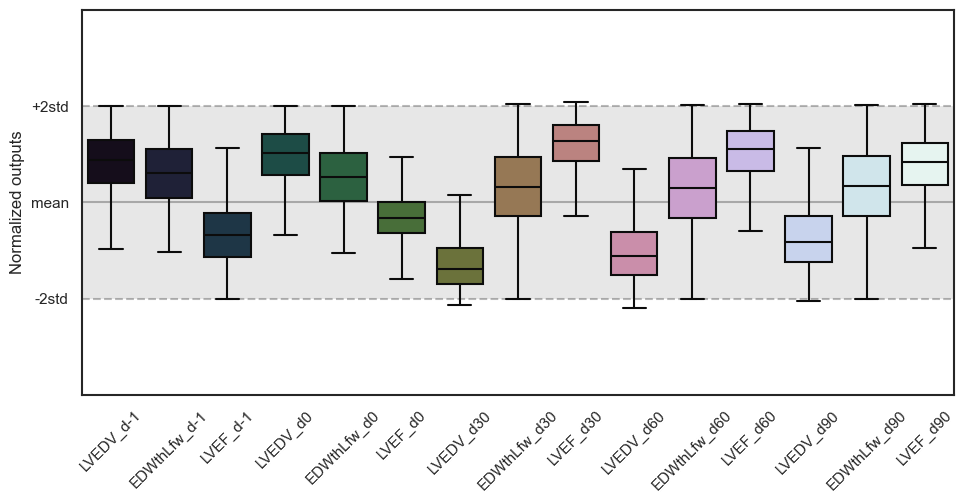

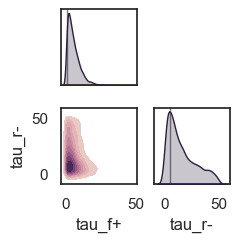

In [29]:
colors = TrueColors(growth_dir)

# Plot the convergence of the implausibility
colors.plot_nroy_data(show_box=True)
colors.plot_nroy_x(n_samples=5000, show_fig=True)

Finally, run all plots. This will take a while, so be patient. The plots are saved in the *results* subdirectory.

In [30]:
colors.roll(nroy_full=False)

## References
[1] Jones, C. E. & Oomen, P. J. A. Synergistic Biophysics and Machine Learning Modeling to Rapidly Predict Cardiac Growth Probability. bioRxiv 2024.07.17.603959 (2024) doi:10.1101/2024.07.17.603959.